# New Deblending Code Walkthrough

Additions to `ts_wep/python/lsst/ts/wep/deblend/BlendedImageDecorator.py`

In [89]:
import os
import numpy as np
from matplotlib import pyplot as plt

from lsst.ts.wep.deblend.AdapThresImage import AdapThresImage
from lsst.ts.wep.deblend.BlendedImageDecorator import BlendedImageDecorator
from lsst.ts.wep.PlotUtil import plotImage
from lsst.ts.wep.Utility import getModulePath
from lsst.ts.wep.SourceProcessor import SourceProcessor

from scipy.ndimage.morphology import binary_opening, binary_closing, binary_erosion, binary_fill_holes, binary_dilation

from scipy.ndimage.interpolation import shift
from scipy.ndimage import convolve
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

#plt.style.use('dark_background')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Changes to deblending algorithm

Overall, we did not change how the deblending works but how the deblender identifies the centers of the objects.
Therefore, we added a new setting in the `ts_wep/policy/default.yaml` file called `newCentroid`. When `newCentroid` is
`True` the deblending code will use the algorithm shown here to run the deblending.

## Example Output

Before going into the basics of the code we show the bare minimum needed to run it.

We start by loading an image of blended donuts.

In [2]:
imageFile = '/astro/store/epyc/users/brycek/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/test_output/boundaryT_21_5/postage/extra_singleSciImg_sensor-R22_S00_star-1_id-1_posX-772_posY-1589.txt'

In [9]:
imageIntra = AdapThresImage()
imageIntra.setImg(imageFile=imageFile)

Text(0.5, 1.0, 'Blended Donuts')

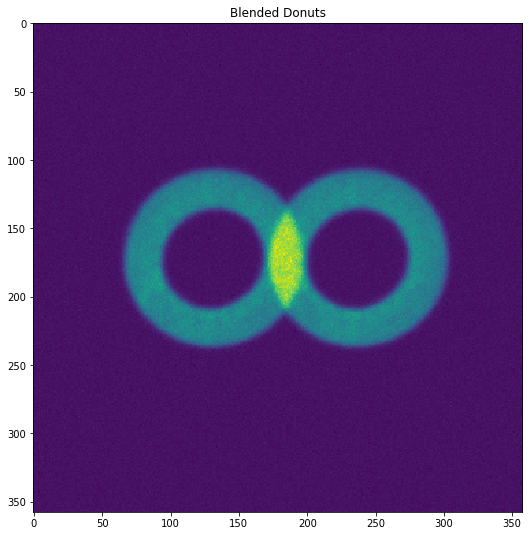

In [27]:
# Plot image
fig = plt.figure(figsize=(9,9))
plt.imshow(imageIntra.image)
plt.title('Blended Donuts')

In [13]:
image = imageIntra.image

# Load image into BlendedImageDecorator object
blendImage = BlendedImageDecorator()
blendImage.setImg(image=image)

In [14]:
# Set up source processor
sourProc = SourceProcessor()
sourProc.config('R22_S00')

We added a method to `SourceProcessor` to create template images based upon a setting defined in the
`ts_wep/policy/default.yaml` file. The setting is called `templateType` and can be either of two types:

`phosim` : If the setting is this then it will grab a template from a phosim image with a donut set at
the center of the appropriate sensor.

`model` : If this is set then the code will use a donut created using the model in
`CompensableImage.makeMask`.

Note that this only affects the deblending if you are running with `newCentroid` set to `True` in the policy file already.

In the example below we run with a `phosim` template.

In [15]:
template = sourProc.createTemplateImage('extra')

In [82]:
# Do the deblending
neighborX, neighborY = [150, 150] # Provide a guess on the location of the neighboring donut
n_donuts = 2 # How many donuts are deblended
sensor_name = 'R22_S00'
imgDeblend, realcx, realcy = blendImage.deblendDonut([neighborX, neighborY], n_donuts, sensor_name, 'extra', template)

Text(0.5, 1.0, 'Deblended Image')

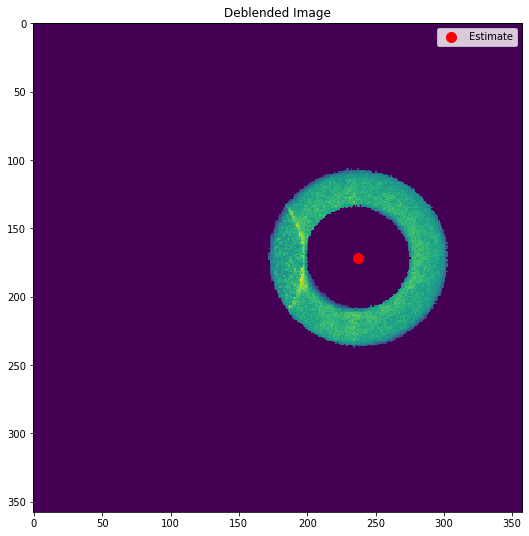

In [83]:
# Plot image
fig = plt.figure(figsize=(9, 9))
plt.imshow(imgDeblend)
plt.scatter(realcx, realcy, c='r', marker='.', label='Estimate', s=400)
plt.legend()
plt.title('Deblended Image')

Text(0.5, 1.0, 'Deblended Image')

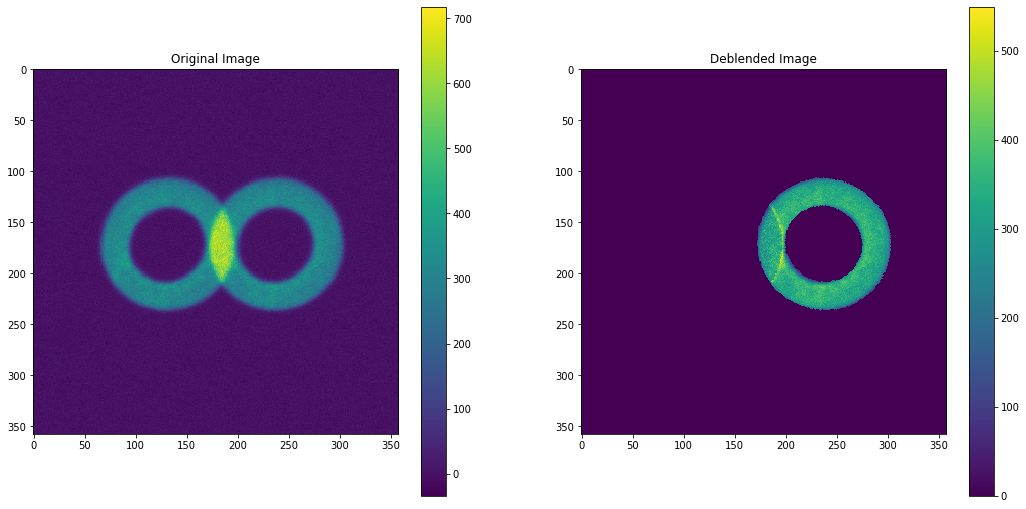

In [84]:
# Plot image
fig = plt.figure(figsize=(18, 9))
fig.add_subplot(1,2,1)
plt.imshow(image)
plt.colorbar()
plt.title('Original Image')
fig.add_subplot(1,2,2)
plt.imshow(imgDeblend)
plt.colorbar()
plt.title('Deblended Image')

## New Method

Text(0.5, 1.0, 'PhoSim Template Image')

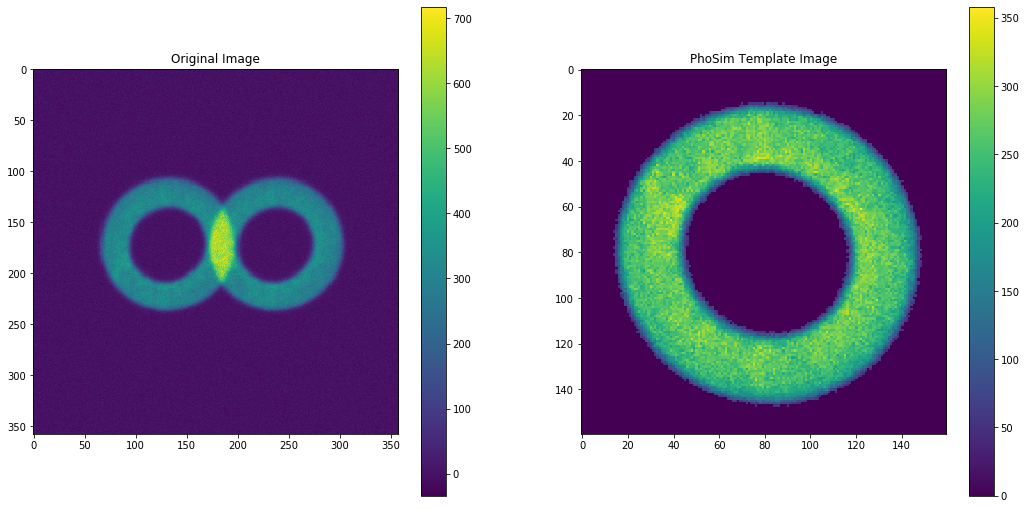

In [32]:
# Plot image
fig = plt.figure(figsize=(18, 9))
fig.add_subplot(1,2,1)
plt.imshow(image)
plt.colorbar()
plt.title('Original Image')
fig.add_subplot(1,2,2)
plt.imshow(template)
plt.colorbar()
plt.title('PhoSim Template Image')

### Create Binary Template

The first step is to take in the template and create a binary image.

In [33]:
templateImage = AdapThresImage()
templateImage.setImg(image=template)
templatecx, templatecy, templateR, templateImgBinary = \
    templateImage.getCenterAndR_adap()
templateImgBinary = binary_closing(templateImgBinary)

Text(0.5, 1.0, 'Binary Template Image')

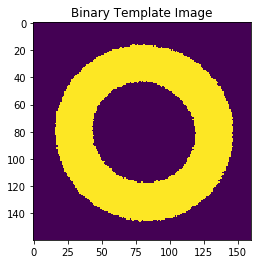

In [35]:
plt.imshow(templateImgBinary)
plt.title('Binary Template Image')

### Create Binary Copy of Blended Donuts Input

Then create a binary image out of the input image. At this point it is similar to the method that already exists except here is where the original centroid gets its x, y coordinates for the donut center. We plot them on the image below and we see that they are well off.

In [37]:
adapcx, adapcy, adapR, adapImgBinary = blendImage.getCenterAndR_adap()

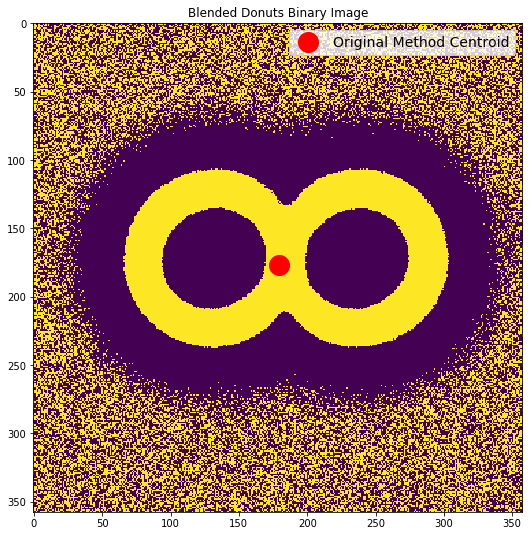

In [44]:
plt.figure(figsize=(9,9))
plt.imshow(adapImgBinary)
plt.scatter(adapcy, adapcx, c='r', s=400, label='Original Method Centroid')
plt.title('Blended Donuts Binary Image')
plt.legend(fontsize=14)

### New Centroid Finding code

#### Convolve binary template and binary blended donut image

For the new centroid finder we run a convolution with the binary template over the binary input image.

In [48]:
temp_convolve = convolve(adapImgBinary, templateImgBinary, mode='constant', cval=0.0)

Text(0.5, 1.0, 'Convolved Image')

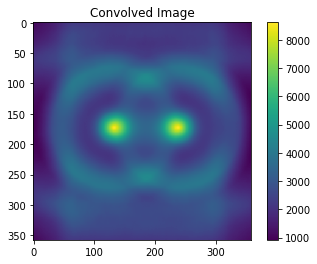

In [50]:
plt.imshow(temp_convolve)
plt.colorbar()
plt.title('Convolved Image')

#### Find peaks in the convolved image

Then we rank the pixel values in the convolved image and only take the pixels that are at least 95% of the maximum.
Since these are binary images the magnitude of the donuts should not matter and donuts of different magnitudes
should have maximum values in the convolved image that are similar.

In [54]:
ranked_convolve = np.argsort(temp_convolve.flatten())[::-1]
cutoff = len(np.where(temp_convolve.flatten() > 0.95*np.max(temp_convolve))[0])
ranked_convolve = ranked_convolve[:cutoff]

Now, we unravel the pixel indicies to get x, y locations again for the pixels with peak values in the convolved image.

In [57]:
nx, ny = np.unravel_index(ranked_convolve, np.shape(adapImgBinary))

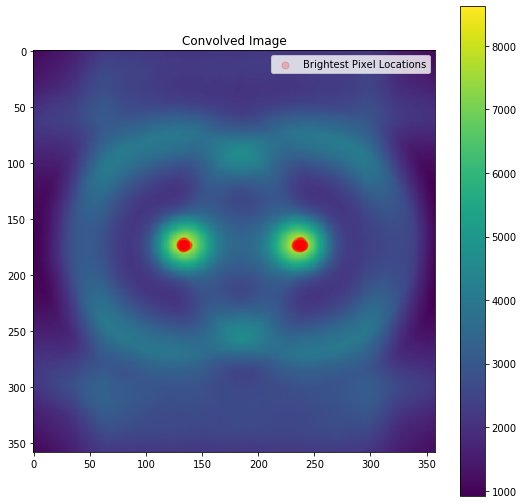

In [68]:
plt.figure(figsize=(9,9))
plt.imshow(temp_convolve)
plt.colorbar()
plt.scatter(ny, nx, c='r', label='Brightest Pixel Locations', s=200, marker='.', alpha=0.2)
plt.title('Convolved Image')
plt.legend()

#### Cluster peaks in to find centroid locations

In [63]:
kmeans = KMeans(n_clusters=n_donuts).fit(np.array([ny, nx]).T)
labels = kmeans.labels_

cent_x = []
cent_y = []

for label_num in range(n_donuts):
    nx_label, ny_label = np.unravel_index(ranked_convolve[labels == label_num][0],
                                          np.shape(adapImgBinary))
    cent_x.append(nx_label)
    cent_y.append(ny_label)

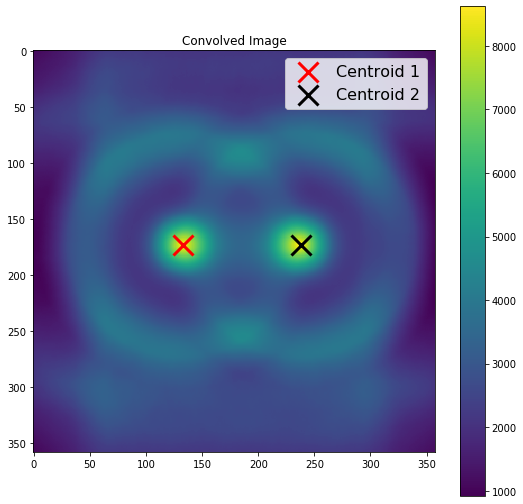

In [73]:
plt.figure(figsize=(9,9))
plt.imshow(temp_convolve)
plt.colorbar()
plt.scatter(cent_y[0], cent_x[0], c='r', label='Centroid 1', s=400, marker='x', lw=3)
plt.scatter(cent_y[1], cent_x[1], c='k', label='Centroid 2', s=400, marker='x', lw=3)
plt.title('Convolved Image')
plt.legend(fontsize=16)

### Determine which centroid is neighbor star by distance to centroids

In [85]:
# Order the centroids to figure out which is neighbor star
centroid_dist = cdist(np.array([[neighborX, neighborY]]),
                      np.array([cent_x, cent_y]).T)
iniGuess_dist_order = np.argsort(centroid_dist[0])
# Update coords of neighbor star and bright star with centroid pos
realcx = cent_x[iniGuess_dist_order[1]]
realcy = cent_y[iniGuess_dist_order[1]]
iniGuessXY = [cent_x[iniGuess_dist_order[0]],
              cent_y[iniGuess_dist_order[0]]]

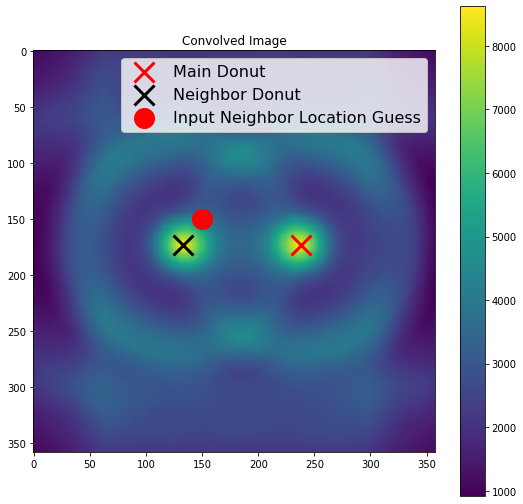

In [87]:
plt.figure(figsize=(9,9))
plt.imshow(temp_convolve)
plt.colorbar()
plt.scatter(realcy, realcx, c='r', label='Main Donut', s=400, marker='x', lw=3)
plt.scatter(iniGuessXY[1], iniGuessXY[0], c='k', label='Neighbor Donut', s=400, marker='x', lw=3)
plt.scatter(neighborY, neighborX, label='Input Neighbor Location Guess', c='r', s=400)
plt.title('Convolved Image')
plt.legend(fontsize=16)

### Create new mask of single donut

Now that we have a template and a donut location we can create a binary mask for the deblender.

In [90]:
imgBinary = np.zeros(np.shape(adapImgBinary))
imgBinary[:np.shape(templateImgBinary)[0],
          :np.shape(templateImgBinary)[1]] += templateImgBinary

xBin = int(realcx - templatecx)
yBin = int(realcy - templatecy)

imgBinary = shift(imgBinary, [xBin, yBin])
imgBinary[imgBinary < 0] = 0

Text(0.5, 1.0, 'New Binary Mask')

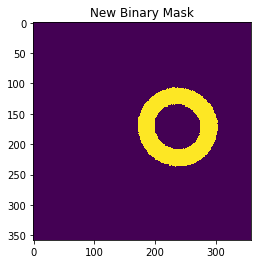

In [92]:
plt.imshow(imgBinary)
plt.title('New Binary Mask')